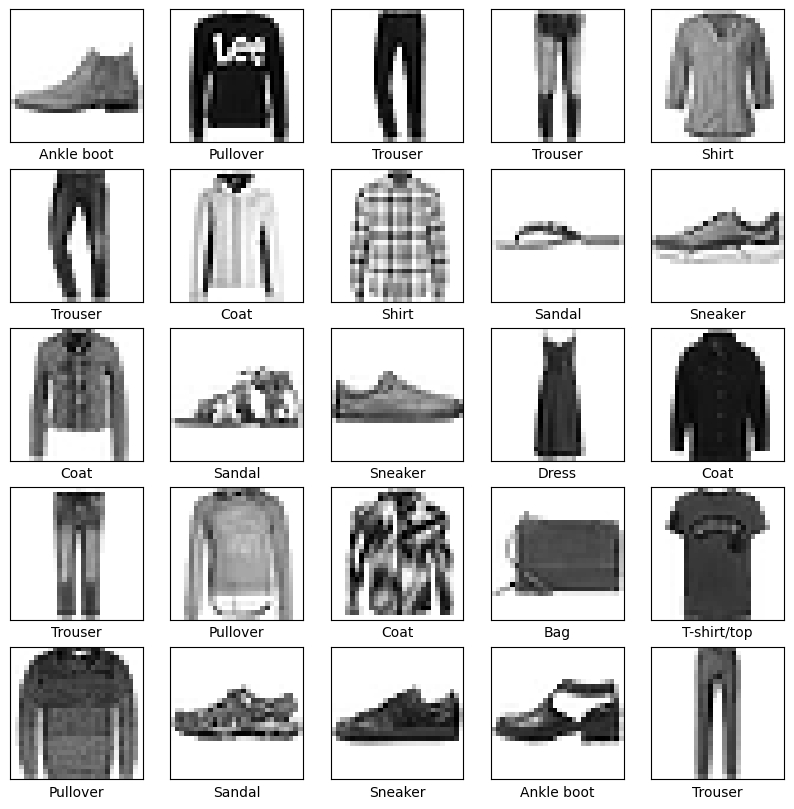

In [15]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# 데이터 불러오기 함수
#gzip으로 압축된 이미지와 레이블 파일을 읽어 NumPy 배열로 변환
def load_data(image_file, label_file):
    with gzip.open(image_file, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
    
    with gzip.open(label_file, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    
    return images, labels

# 데이터셋 로드
test_images, test_labels = load_data('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

# 데이터 전처리: 이미지 데이터 스케일 조정 [0, 1]로 변환 및 PyTorch Tensor로 변환
test_images = torch.tensor(test_images, dtype=torch.float32) / 255.0
test_labels = torch.tensor(test_labels, dtype=torch.long)

# 데이터 분할: 70%는 훈련 데이터, 30%는 테스트 데이터
split_index = int(len(test_images) * 0.7)
train_images, train_labels = test_images[:split_index], test_labels[:split_index]
test_images, test_labels = test_images[split_index:], test_labels[split_index:]

# 데이터 로더 생성
train_dataset = TensorDataset(train_images.unsqueeze(1), train_labels)
test_dataset = TensorDataset(test_images.unsqueeze(1), test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Fashion-MNIST 클래스 레이블 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 이미지와 레이블을 시각화
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [16]:
# 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)  # input channels=1, output channels=32, kernel_size=3
        self.pool = nn.MaxPool2d(2, 2)     # kernel_size=2, stride=2
        self.fc1 = nn.Linear(32 * 13 * 13, 128)  # 13x13는 Conv2d와 MaxPool2d에 따라 계산됨
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = x.view(-1, 32 * 13 * 13)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 초기화
model = Net()

# 모델 컴파일
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/5, Loss: 0.7511985883048681
Epoch 2/5, Loss: 0.4643242923908582
Epoch 3/5, Loss: 0.3987230422085823
Epoch 4/5, Loss: 0.3496452180762269
Epoch 5/5, Loss: 0.31407594847488624


총 5번의 훈련과정을 거쳐 데이터 로스를 최소한으로 줄입니다.

테스트 정확도: 86.63333333333334%


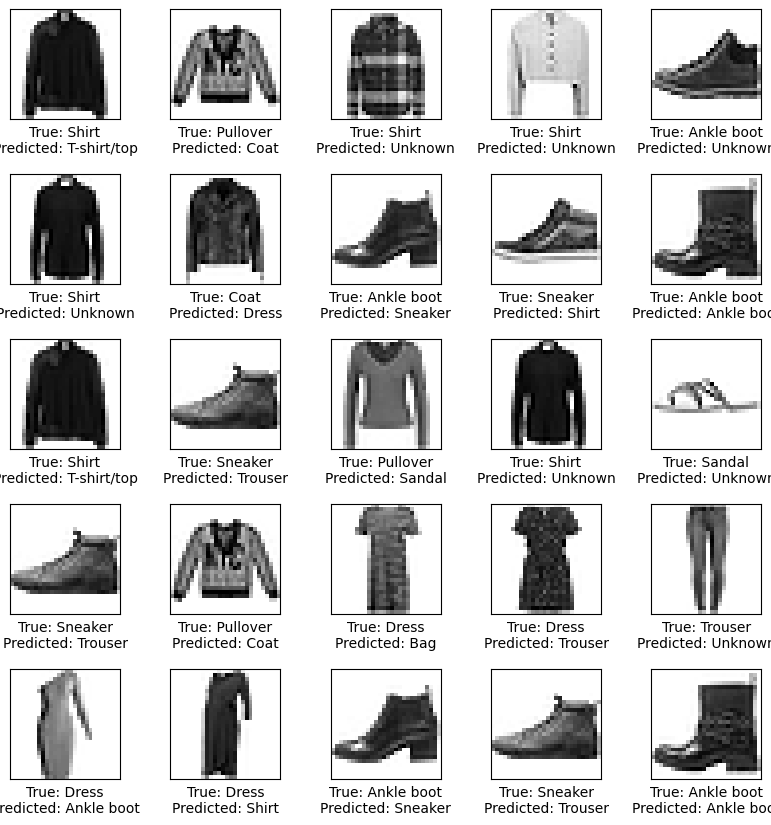

In [26]:
# 모델 평가
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"테스트 정확도: {100 * correct / total}%")

# 잘못 분류된 이미지 찾기
misclassified_index = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        batch_misclassified_index = (predicted != labels).nonzero().squeeze().tolist()
        if isinstance(batch_misclassified_index, int):
            batch_misclassified_index = [batch_misclassified_index]
        misclassified_index.extend(batch_misclassified_index)

# 잘못 분류된 이미지 시각화
plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)  # 행간 조정
for i, index in enumerate(misclassified_index[:25]):
    if i >= len(misclassified_index):  # Check if index exceeds the length of misclassified_index
        break
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[index], cmap=plt.cm.binary)
    
    true_label = class_names[test_labels[index].item()] if 0 <= test_labels[index].item() < len(class_names) else "Unknown"
    
    # Check if the index is within the bounds of the predicted tensor
    if 0 <= index < len(predicted):
        pred_label_index = predicted[index].item()
        pred_label = class_names[pred_label_index] if 0 <= pred_label_index < len(class_names) else "Unknown"
    else:
        pred_label = "Unknown"
        
    plt.xlabel(f"True: {true_label}\nPredicted: {pred_label}")
plt.show()




실제 이미지의 레이블은 shirt 이지만 모델이 분류하는 과정에서 T-shirt/top 등 잘못된 레이블로 측정된 것을 확인합니다.
True는 이미지의 실제 레이블이며, Predicted는 모델이 내린 잘못된 결과입니다.